_______________________________

With distance model
_______________________________

In [1]:
import gymnasium as gym
import numpy as np
import torch
import os

import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.env_wrappers import EnvBuilder
from src.ppo_agent_v2 import PPOAgent
from src.env_wrappers import GoalObservationWrapper
import src.distance_models as distance_models
from src.utils import trajectories_to_dataset

os.environ['WANDB_API_KEY'] = 'd58c31e07030724bbab6b7e8edc93edacd934c87'

# Check for GPU
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "CPU")

/home/user7/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment FetchSlide-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/user7/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment FetchSlide-v3 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/user7/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment FetchPickAndPlace-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/user7/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment FetchPickAndPlace-v3 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/user7/.venv/lib/python3.10/site-pack

CUDA available: True
Current device: 0
Device name: Tesla V100-SXM3-32GB


In [2]:
env_id = 'PointMaze_UMaze-v3'
train_episodes = 10000
max_episode_steps = 512
seed = 0

torch.manual_seed(seed); np.random.seed(seed)

# Initialize environment
c = 'c'; U_map = [
    [1, 1, 1, 1, 1],
    [1, c, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [1, c, 0, 0, 1],
    [1, 1, 1, 1, 1]
]
builder = EnvBuilder(env_id=env_id, maze_map=U_map, max_episode_steps=max_episode_steps, seed=seed)
obs_dim, act_dim = builder.get_obs_act_dim()

In [3]:
N_envs = 1
def make_env(env_id, idx, capture_video, run_name, gamma):
    def thunk():
        # Set render_mode to 'rgb_array' if capturing video
        render_mode = "rgb_array" if capture_video and idx == 0 else None
        env = gym.make(env_id, render_mode=render_mode)
        # env = gym.wrappers.FlattenObservation(env)
        env = GoalObservationWrapper(env)
        if capture_video and idx == 0:
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        env = gym.wrappers.RecordEpisodeStatistics(env)
        return env
    return thunk

In [14]:
def train_supervised_distance(
        envs,
        env,
        agent,
        distance_model,
        *,
        num_stage: int = 30,
        eval_size: int = 10,
        max_episode_steps: int = 350,
        d_samples: int = 500000,
        en_reward=False,
    ):
        for episode in range(num_stage):
            agent.distance_model = distance_model
            agent.train_ppo(envs, use_distance_shaping = en_reward, verbose=False)
            trajectories = agent.evaluate_ppo(env, num_episodes=eval_size, max_episode_steps=max_episode_steps)

            dataset = trajectories_to_dataset(trajectories, samples=d_samples)
            # sup_model = SupervisedDistanceEstimator(input_dim=4)
            sup_loss = distance_model.train_from_data(dataset, epochs=20, batch_size=16192)          
            print(f"Finish {episode=}, dd loss = {sup_loss}\n")


In [15]:
envs = gym.vector.SyncVectorEnv([make_env(env_id, seed, 0, False, "test")])
env = builder()

In [16]:
EXPERIMENTS = {
    # tag      include_distance_state  use_distance_shaping
    "base"            : (False, False),
    "reward_only"     : (False, True ),
    "state_only"      : (True , False),
    "reward_and_state": (True , True ),
}


In [ ]:
en_state, en_reward = EXPERIMENTS["reward_and_state"]

distance_model = distance_models.SupervisedDistanceEstimator(input_dim=4)
agent = PPOAgent(state_dim=obs_dim, action_dim=act_dim, total_timesteps=10000, distance_model=distance_model, include_distance_state=en_state)
train_supervised_distance(envs, env, agent, distance_model, en_reward=en_reward)

/home/user7/.venv/lib/python3.10/site-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
/home/user7/.venv/lib/python3.10/site-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.05it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 421.36it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:00<00:00, 20.44it/s]


eval_losses[0]=0.6720230957571982 -> eval_losses[-1]=0.09512648539157668
Finish episode=0, dd loss = 0.08622778207063675



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 315.81it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:01<00:00, 19.72it/s]


eval_losses[0]=0.12683867698492005 -> eval_losses[-1]=0.09126473292691895
Finish episode=1, dd loss = 0.08512604981660843



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.05it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 497.65it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:01<00:00, 19.43it/s]


eval_losses[0]=0.07121964497951706 -> eval_losses[-1]=0.051505674106602124
Finish episode=2, dd loss = 0.04740762338042259



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 502.22it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:00<00:00, 20.20it/s]


eval_losses[0]=0.03702075709008167 -> eval_losses[-1]=0.031592293672783434
Finish episode=3, dd loss = 0.02896839566528797



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 500.95it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:01<00:00, 19.67it/s]


eval_losses[0]=0.05141668782281717 -> eval_losses[-1]=0.04446287440303156
Finish episode=4, dd loss = 0.0409688875079155



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 508.84it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:01<00:00, 19.96it/s]


eval_losses[0]=0.06841157459077381 -> eval_losses[-1]=0.05852973000155731
Finish episode=5, dd loss = 0.05286822095513344



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.98it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 497.12it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:01<00:00, 17.97it/s]


eval_losses[0]=0.03268489884115665 -> eval_losses[-1]=0.018514014124738284
Finish episode=6, dd loss = 0.016932694241404533



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.01it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 500.01it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:01<00:00, 19.38it/s]


eval_losses[0]=0.0559177257584311 -> eval_losses[-1]=0.04652307588528689
Finish episode=7, dd loss = 0.04352080076932907



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.85it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 490.11it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:01<00:00, 19.22it/s]


eval_losses[0]=0.054680894955184106 -> eval_losses[-1]=0.040612510098175354
Finish episode=8, dd loss = 0.036736514419317245



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.98it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 315.52it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:01<00:00, 18.31it/s]


eval_losses[0]=0.12849472366958228 -> eval_losses[-1]=0.11557121944321878
Finish episode=9, dd loss = 0.10647116601467133



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.01it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 496.90it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:01<00:00, 19.99it/s]


eval_losses[0]=0.03896858781411138 -> eval_losses[-1]=0.029627968248470807
Finish episode=10, dd loss = 0.027238639071583748



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 510.92it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:01<00:00, 17.42it/s]


eval_losses[0]=0.17477248013349597 -> eval_losses[-1]=0.14298615076481175
Finish episode=11, dd loss = 0.13299201428890228



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 494.73it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:01<00:00, 19.43it/s]


eval_losses[0]=0.03320619297978094 -> eval_losses[-1]=0.02149039816618758
Finish episode=12, dd loss = 0.020214274525642395



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.01it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 498.79it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:01<00:00, 18.87it/s]


eval_losses[0]=0.12157885174418605 -> eval_losses[-1]=0.10074708585855309
Finish episode=13, dd loss = 0.0932135358452797



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.02it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 495.18it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:00<00:00, 20.13it/s]


eval_losses[0]=0.03299781469807672 -> eval_losses[-1]=0.021166420363112542
Finish episode=14, dd loss = 0.019419576972723007



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 504.83it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


eval_losses[0]=0.04321713925992136 -> eval_losses[-1]=0.037461784083977885
Finish episode=15, dd loss = 0.03517039865255356



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.99it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 487.98it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:01<00:00, 19.26it/s]


eval_losses[0]=0.07055298933027063 -> eval_losses[-1]=0.034624026986055594
Finish episode=16, dd loss = 0.030550606548786163



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.88it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 379.72it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:01<00:00, 19.31it/s]


eval_losses[0]=0.032295226712823574 -> eval_losses[-1]=0.028514734819481934
Finish episode=17, dd loss = 0.025995900854468346



Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.95it/s]


Success rate: 0.00%, avg_return: 0.00 ± 0.00


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 491.38it/s]


Trajectories processed : 10
Generated samples      : 451500 (train 361200 / eval 90300)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 20/20 [00:00<00:00, 20.05it/s]


eval_losses[0]=0.008439054520819275 -> eval_losses[-1]=0.007362686824692972
Finish episode=18, dd loss = 0.00685070501640439



Evaluating:  40%|████████████████████▊                               | 4/10 [00:02<00:03,  1.85it/s]

In [ ]:
agent.save_model(path="runs/base_2.cleanrl_model")

Model saved to runs/ppo_both.cleanrl_model_2


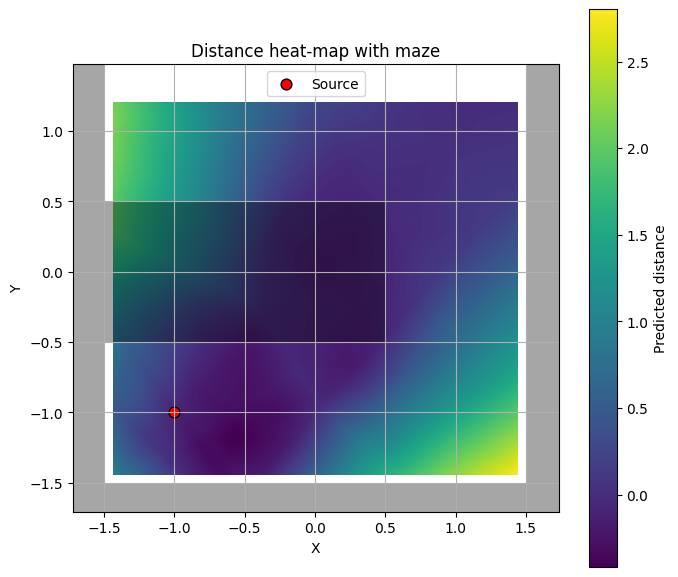

In [13]:
distance_model.plot_distance_heatmap(env, source_point=(-1, -1))

In [10]:
model_path = "results/base/ppo_base.cleanrl_model"
agent = PPOAgent(state_dim=obs_dim, action_dim=act_dim, total_timesteps=10000, distance_model=distance_model, include_distance_state=False)
agent.agent.load_state_dict(torch.load(model_path, map_location="cuda"))
_ = evaluate_ppo(agent, env, num_episodes=100, max_episode_steps=300)


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


charts/SPS,▇█▇██▇▇▇▇▇▆██▇▇▇▁▄▃▆██▇▇█▇█▆▇▇▇▇█▇▇▇▇▇▇█
charts/episodic_length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/episodic_return,▃▁▃▁▁▂▁▁▃▄▁▁▁▅▇▇▅█▇█▇█▁▆▁█▁▁▄▄▄▆▆▄▄█▃▁▄▆
global_step,▇█▃▆▇▄█▄▄▃▂▃▃▃▇▅▅▃█▁█▁▃▆▆▆▆▇▄▅▇▆██▇▃▆█▄▄
losses/entropy,██▇▇▇▅▅▅▅▅▄▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁
losses/policy_loss,▆▂▃▂█▅▁▇▄▆▆▄▄▃▆▆▆▄▆▃▆▂▅▅▃▇▁▆▆▆▃▂▃▃▅▅▆▅▅▆
losses/value_loss,▁▁▂▂▂▂▂▃▄▃▆█▇█▆▇▇▆▇▇▆▆█▅▇▅█▆▅██▆▇▆▅▄▄▄▅▄
sypervised_losses/eval_loss,█▅▄▄▄▄▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sypervised_losses/train_loss,██▆▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
charts/SPS,307
charts/episodic_length,300


/home/user7/.venv/lib/python3.10/site-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


NameError: name 'evaluate_ppo' is not defined

In [ ]:
trajectories = agent.evaluate_ppo(env, num_episodes=100, max_episode_steps=300)

In [11]:
import gymnasium as gym
import gymnasium_robotics  # If not used elsewhere, you may remove this import.
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.tensorboard import SummaryWriter
from tqdm import trange
import wandb
import time
import random

def evaluate_ppo(
    agent_cls,
    env: gym.Env,
    *,
    num_episodes: int = 100,
    max_episode_steps: int | None = 170,
    deterministic: bool = True,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    agent_cls.agent.to(device).eval()

    trajectories   = []
    ep_returns     = []
    success_count  = 0

    for _ in trange(num_episodes, desc="Evaluating", ncols=100):
        obs_np, _ = env.reset()
        obs = torch.as_tensor(obs_np, dtype=torch.float32)
        obs = agent_cls._augment_obs(obs, device)

        episode_traj = []
        for step in range(max_episode_steps):
            ball_x, ball_y = obs.cpu().numpy()[:2]
            episode_traj.append((ball_x, ball_y))

            with torch.no_grad():
                action, *_ = agent_cls.agent.get_action_and_value(obs.unsqueeze(0), None)
            next_obs_np, _, terminated, truncated, info = env.step(action.squeeze(0).cpu().numpy())
            obs = torch.as_tensor(next_obs_np, dtype=torch.float32)
            obs = agent_cls._augment_obs(obs, device)

            if info.get("success", False):
                success_count += 1
                ep_returns.append(max_episode_steps - step)   # reward
                break
            if terminated or truncated:
                break

        trajectories.append(episode_traj)

    # ---------- statistics ----------
    success_rate = success_count / num_episodes
    avg_return   = np.mean(ep_returns) if ep_returns else 0.0
    std_return   = np.std(ep_returns, ddof=1) if len(ep_returns) > 1 else 0.0

    print(f"Success rate: {success_rate:.2%}, "
        f"avg_return: {avg_return:.2f} ± {std_return:.2f}")

    return trajectories


In [12]:
_ = evaluate_ppo(agent, env, num_episodes=100, max_episode_steps=300)

Evaluating: 100%|█████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.91it/s]

Success rate: 50.00%, avg_return: 38.02 ± 15.05
